# Geo-AutoML with Scikit-map

This tutorial presents a modeling strategy for [Fraction of Absorbed Photosynthetically Active Radiation (FAPAR)](https://doi.org/10.7717/peerj.16972) using in-situ data and based on Automated Machine Learning (AutoML), including a example of spatial prediction and model output saved as raster data.

The dataset presented here was prepared within the context of [OEMC Hackthon 2023](https://earthmonitor.org/events/hackathon2023/). The Open-Earth-Monitor Cyberinfrastructure project has received funding from the European Union's Horizon Europe research and innovation programme under grant agreement No. 101059548.

# Installing libraries

It's possible to use `pip` for installing [Scikit-map](https://github.com/openlandmap/scikit-map):

In [ ]:
!pip install -e 'git+https://github.com/openlandmap/scikit-map#egg=scikit-map[full]'

and [EvalML](https://github.com/alteryx/evalml):

In [ ]:
!pip install evalml

# Data downloading

First, let's download the [FAPAR dataset](https://zenodo.org/records/13874505) from Zenodo using [Requests](https://pypi.org/project/requests/):

In [1]:
import requests

zenodo_url = 'https://zenodo.org/records/13874505'
train_url = f'{zenodo_url}/files/train.csv?download=1'

r_train = requests.get(train_url, allow_redirects=True)
f_train = 'train.csv'

print(f"Downloading {f_train}")
open(f_train, 'wb').write(r_train.content)

794104

For enabling spatial predictions it's necessary extract the file `raster_data_2020.zip`:

In [2]:
import zipfile
import os

raster_url = f'{zenodo_url}/files/raster_data_2020.zip?download=1'

r_raster = requests.get(raster_url, allow_redirects=True)
f_raster = 'raster_data_2020.zip'

print(f"Downloading & extracting {f_raster}")
open(f_raster, 'wb').write(r_raster.content)

with zipfile.ZipFile(f_raster,"r") as zip_ref:
    zip_ref.extractall(".")
    os.unlink(f_raster)

# Data reading

Now, let's load the train set using [Pandas](https://pandas.pydata.org/),

In [3]:
import pandas as pd

f_train = 'train.csv'
df_train = pd.read_csv(f_train)

print(f"df_train shape={df_train.shape}")

df_train shape=(3461, 36)


... and check all columns available:

In [4]:
print("Columns:")
for i, c, t in zip(range(0, df_train.shape[0]), df_train.columns, df_train.dtypes):
    print(f' - {i}: {c} ({t})')

Columns:
 - 0: sample_id (int64)
 - 1: station (int64)
 - 2: month (int64)
 - 3: fapar (float64)
 - 4: modis_blue (float64)
 - 5: modis_red (float64)
 - 6: modis_nir (float64)
 - 7: modis_mir (float64)
 - 8: modis_evi (float64)
 - 9: modis_ndvi (float64)
 - 10: modis_lst_day_p05 (float64)
 - 11: modis_lst_day_p50 (float64)
 - 12: modis_lst_day_p95 (float64)
 - 13: modis_lst_night_p05 (float64)
 - 14: modis_lst_night_p50 (float64)
 - 15: modis_lst_night_p95 (float64)
 - 16: wv_yearly_p25 (float64)
 - 17: wv_yearly_p50 (float64)
 - 18: wv_yearly_p75 (float64)
 - 19: wv_monthly_lt_p50 (float64)
 - 20: wv_monthly_lt_p25 (float64)
 - 21: wv_monthly_lt_p75 (float64)
 - 22: wv_monthly_lt_sd (float64)
 - 23: wv_monthly_ts_raw (float64)
 - 24: wv_monthly_ts_smooth (float64)
 - 25: accum_pr_monthly (float64)
 - 26: dtm_slope (float64)
 - 27: dtm_aspect-cosine (float64)
 - 28: dtm_aspect-sine (float64)
 - 29: dtm_downlslope.curvature (float64)
 - 30: dtm_upslope.curvature (float64)
 - 31: dtm_ele

What exactly is station and month?
- **Station**: Unique spatial in-situ location for where FAPAR was estimated (see [GBOV](https://land.copernicus.eu/en/products/GBOV))
- **Month**: Specific month where FAPAR was estimated

''

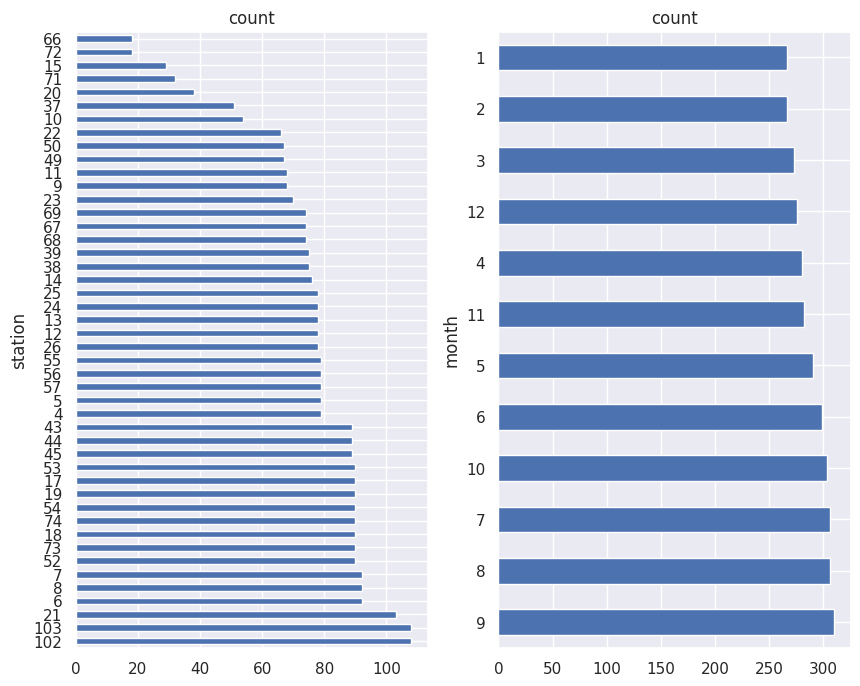

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook')

fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,8))

df_train['station'].value_counts().plot(kind='barh', ax = axes[0], subplots=True)
df_train['month'].value_counts().plot(kind='barh', ax = axes[1], subplots=True)
;

Let's get the _features/covariates_, _target_ and _spatial cross-validation_ columns: 

In [7]:
covs = list(df_train.columns[4:])
target = 'fapar'
cv_group_col = 'station'

For the calibration set (early stopping), let's randomly select data from **20%** of the station:

In [8]:
calib_groups = pd.DataFrame(df_train[cv_group_col].unique()).sample(frac=0.2).iloc[:,0].to_numpy()

df_calib = df_train[df_train[cv_group_col].isin(calib_groups)]
df_train = df_train.drop(index=df_calib.index)

print(f"df_train shape={df_train.shape}")
print(f"df_calib shape={df_calib.shape}")

df_train shape=(2828, 36)
df_calib shape=(633, 36)


# Data checks

The FAPAR dataset is ready for modeling, so it has no NA values or missing columns, but it's possible to use [EvalML for several data check](https://evalml.alteryx.com/en/stable/user_guide/data_checks.html):

In [9]:
from evalml.data_checks import NullDataCheck

# Simulate rows & column with null
# df_train.loc[df_train.sample(frac=0.03).index, ['modis_evi']] = np.nan
# df_train.loc[df_train.sample(frac=0.01).index, ['dtm_slope']] = np.nan

null_check = NullDataCheck(pct_moderately_null_col_threshold=0.02, pct_null_col_threshold=0.05, pct_null_row_threshold=0.01)
validation = null_check.validate(df_train)

for warning in [msg for msg in validation if msg["level"] == "warning"]:
    print("Warning:", warning["message"])

for error in [msg for msg in validation if msg["level"] == "error"]:
    print("Error:", error["message"])

Including target distribution check:

In [10]:
from scipy.stats import lognorm
from evalml.data_checks import TargetDistributionDataCheck

#data = np.tile(np.arange(10) * 0.01, (100, 10))
#X = pd.DataFrame(data=data)
#y = pd.Series(lognorm.rvs(s=0.4, loc=1, scale=1, size=100))

target_dist_check = TargetDistributionDataCheck()
validation = target_dist_check.validate(df_train[covs], df_train[target])

for warning in [msg for msg in validation if msg["level"] == "warning"]:
    print("Warning:", warning["message"])

for error in [msg for msg in validation if msg["level"] == "error"]:
    print("Error:", error["message"])

Let's plot target distribution:

<Axes: title={'center': 'FAPAR'}, ylabel='Frequency'>

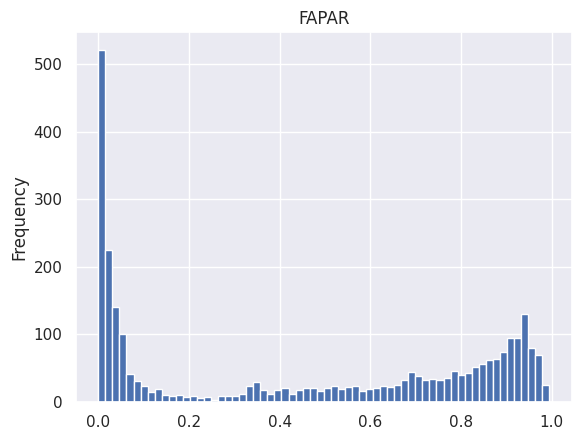

In [11]:
df_train[target].plot(kind='hist', bins=64, title='FAPAR')

# Automated Modeling

AutoML is the process of automating the construction, training and evaluation of ML models. Given a data and some configuration, AutoML searches for the most effective and accurate ML model or models to fit the dataset. During the search, AutoML will explore different combinations of model type, model parameters and model architecture ([see more information](https://evalml.alteryx.com/en/stable/user_guide/automl.html#Automated-Machine-Learning-(AutoML)-Search)):

In [12]:
from evalml.problem_types import detect_problem_type
from evalml.automl import get_default_primary_search_objective

problem_type = detect_problem_type(df_train[target]).name

search_params = {
    'X_train': df_train[covs],
    'y_train': df_train[target],
    'X_holdout': df_calib[covs],
    'y_holdout': df_calib[target],
    'problem_type': problem_type,
    'objective': get_default_primary_search_objective(problem_type),
    'optimize_thresholds': True,
    'verbose': True,
    'max_iterations': 10
}


For enabling plot visualization in Google Colab:

In [13]:
# Only for Google Colab
# from google.colab import output
# output.enable_custom_widget_manager()

Let's searching for the best model:

In [ ]:
from evalml import AutoMLSearch

automl = AutoMLSearch(**search_params)
automl.search(interactive_plot=True)

AutoMLSearch will use the holdout set to score and rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for R2. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 10 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type': 'scatter',
              'uid': 'b96e9800-752e-4196-9679-e1aa0419de20',
              'x': [],
              'y': []},
             {'marker': {'color': 'gray'},
              'mode': 'markers',
              'name': 'Iter score',
              'type': 'scatter',
              'uid': 'b4f9a83b-a1a0-43b8-b553-bf4a80c4be52',
              'x': [],
              'y': []}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': ('Pipeline Search: Iteration vs.' ... 'ore at current iteration</sub>')},
               'xaxis': {'rangemode': 'tozero', 'title': {'text': 'Iteration'}},
               'yaxis': {'title': {'text': 'Validation Score'}}}
})

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean R2: -0.002
	Starting holdout set scoring
	Finished holdout set scoring - R2: -0.017

*****************************
* Evaluating Batch Number 1 *
*****************************

Random Forest Regressor w/ Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean R2: 0.962
	Starting holdout set scoring
	Finished holdout set scoring - R2: 0.940

*****************************
* Evaluating Batch Number 2 *
*****************************

Extra Trees Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean R2: 0.925
	Starting holdout set scoring
	Finished holdout set scoring - R2: 0.929
XGBoost Regressor w/ Imputer + Select Columns Transformer:
	Starting cross validation
	Finished cross validation - mean R2: 0.975
	Starting holdout set sc

{1: {'Random Forest Regressor w/ Imputer + RF Regressor Select From Model': 1.9972865581512451,
  'Total time of batch': 2.145754337310791},
 2: {'Extra Trees Regressor w/ Imputer + Select Columns Transformer': 0.8007333278656006,
  'XGBoost Regressor w/ Imputer + Select Columns Transformer': 1.1035399436950684,
  'LightGBM Regressor w/ Imputer + Select Columns Transformer': 0.73952317237854,
  'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer': 0.9050912857055664,
  'Total time of batch': 4.04857611656189},
 3: {'XGBoost Regressor w/ Imputer + Select Columns Transformer': 3.907210350036621,
  'Random Forest Regressor w/ Imputer + Select Columns Transformer': 9.916919708251953,
  'Elastic Net Regressor w/ Imputer + Standard Scaler + Select Columns Transformer': 1.4622280597686768,
  'Total time of batch': 18.037806034088135}}

What is the final score?

In [14]:
automl.rankings

,id,pipeline_name,search_order,ranking_score,holdout_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,3,XGBoost Regressor w/ Imputer + Select Columns ...,3,0.954804,0.954804,0.974630,0.003922,56084.017426,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,7,Random Forest Regressor w/ Imputer + Select Co...,7,0.948839,0.948839,0.974258,0.003348,56062.626932,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,1,Random Forest Regressor w/ Imputer + RF Regres...,1,0.940437,0.940437,0.961645,0.002890,55338.133244,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,5,Elastic Net Regressor w/ Imputer + Standard Sc...,5,0.934879,0.934879,0.885303,0.006883,50952.981975,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,4,LightGBM Regressor w/ Imputer + Select Columns...,4,0.933315,0.933315,0.952573,0.003646,54817.032165,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,2,Extra Trees Regressor w/ Imputer + Select Colu...,2,0.929098,0.929098,0.925035,0.006573,53235.213553,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mean Baseline Regression Pipeline,0,-0.016651,-0.016651,-0.001741,0.001506,0.000000,False,{'Baseline Regressor': {'strategy': 'mean'}}


Here is the winner:

In [15]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


*************************************************************
* XGBoost Regressor w/ Imputer + Select Columns Transformer *
*************************************************************

Problem Type: regression
Model Family: XGBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * boolean_impute_strategy : most_frequent
	 * categorical_fill_value : None
	 * numeric_fill_value : None
	 * boolean_fill_value : None
2. Select Columns Transformer
	 * columns : ['modis_blue', 'modis_red', 'modis_nir', 'modis_mir', 'modis_evi', 'modis_ndvi', 'modis_lst_day_p95', 'wv_yearly_p25', 'wv_yearly_p50', 'wv_monthly_lt_p75', 'wv_monthly_lt_sd', 'dtm_aspect-cosine', 'dtm_downlslope.curvature', 'dtm_upslope.curvature', 'dtm_elevation', 'dtm_vbf']
3. XGBoost Regressor
	 * eta : 0.1
	 * max_depth : 6
	 * min_child_weight : 1
	 * n_estimators : 100
	 * n_jobs : -1

Training
Training for regression problems.
Total training time (including CV

Let's keep it a variable for later:

In [16]:
best_pipeline = automl.best_pipeline

EvalML provides several functions for [model understanding](https://evalml.alteryx.com/en/stable/user_guide/model_understanding.html), including feature importance

In [17]:
best_pipeline.feature_importance
# Depends on Plotly
#best_pipeline.graph_feature_importance()

,feature,importance
0,modis_blue,0.418078
1,modis_red,0.248398
2,modis_mir,0.109823
3,dtm_elevation,0.054154
4,wv_yearly_p25,0.033024
5,dtm_aspect-cosine,0.031761
6,dtm_upslope.curvature,0.018277
7,dtm_downlslope.curvature,0.015245
8,modis_ndvi,0.012756
9,wv_monthly_lt_sd,0.011448


... and also permutation importance: 

In [18]:
from evalml.model_understanding import calculate_permutation_importance
from evalml.model_understanding import graph_permutation_importance

calculate_permutation_importance(
    best_pipeline, df_calib[covs],
    df_calib[target], "r2"
)

# Depends on Plotly
#graph_permutation_importance(
#    best_pipeline, df_calib[covs],
#    df_calib[target], "r2"
#)


,feature,importance
0,modis_mir,0.279790
1,modis_blue,0.222685
2,dtm_elevation,0.154621
3,modis_red,0.044687
4,modis_evi,0.042661
5,wv_monthly_lt_p75,0.019161
6,modis_ndvi,0.015239
7,modis_lst_day_p95,0.009860
8,wv_yearly_p25,0.008094
9,wv_yearly_p50,0.006828


# Spatial prediction

Spatial prediction depends upon reading all input raster data in **same order** and **data structure** (dtype) then feature/covariates used in the training phase. For implementing it, let's use [scikit-map](https://github.com/openlandmap/scikit-map);

In [19]:
from skmap.misc import find_files

year = '2020'
month = '06'

raster_files = []

for c in covs:
    raster_files += find_files(f'raster_data/monthly/{year}-{month}', f'*{c}*')
    raster_files += find_files(f'raster_data/annual/{year}', f'*{c}*')
    raster_files += find_files(f'raster_data/static/', f'*{c}*')

print("Raster files")
for c, r in zip(covs,raster_files):
    print(f"- {c} => {str(r)}")

Raster files
- modis_blue => raster_data/monthly/2020-06/modis_blue.tif
- modis_red => raster_data/monthly/2020-06/modis_red.tif
- modis_nir => raster_data/monthly/2020-06/modis_nir.tif
- modis_mir => raster_data/monthly/2020-06/modis_mir.tif
- modis_evi => raster_data/monthly/2020-06/modis_evi.tif
- modis_ndvi => raster_data/monthly/2020-06/modis_ndvi.tif
- modis_lst_day_p05 => raster_data/monthly/2020-06/modis_lst_day_p05.tif
- modis_lst_day_p50 => raster_data/monthly/2020-06/modis_lst_day_p50.tif
- modis_lst_day_p95 => raster_data/monthly/2020-06/modis_lst_day_p95.tif
- modis_lst_night_p05 => raster_data/monthly/2020-06/modis_lst_night_p05.tif
- modis_lst_night_p50 => raster_data/monthly/2020-06/modis_lst_night_p50.tif
- modis_lst_night_p95 => raster_data/monthly/2020-06/modis_lst_night_p95.tif
- wv_yearly_p25 => raster_data/annual/2020/wv_yearly_p25.tif
- wv_yearly_p50 => raster_data/annual/2020/wv_yearly_p50.tif
- wv_yearly_p75 => raster_data/annual/2020/wv_yearly_p75.tif
- wv_mon

In this example, EvalML is expecting a [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html):

In [26]:
from skmap.io import read_rasters, save_rasters
data = read_rasters(raster_files=raster_files)
raster_shape = data.shape

data = pd.DataFrame(data.reshape(-1, raster_shape[-1]), columns=covs)

print(f"Raster data shape: {raster_shape}")
print(f"Model input shape: {data.shape}")

Raster data shape: (500, 620, 32)
Model input shape: (310000, 32)


Let's run the spatial prediction,

In [27]:
pred_fapar = best_pipeline.predict(data)
pred_fapar = pred_fapar.to_numpy().reshape((raster_shape[0],raster_shape[1]))

# Scale values to 0--100
pred_fapar = pred_fapar * 100

print(f"Model output shape: {pred_fapar.shape}")

Model output shape: (500, 620)


... visualize the result

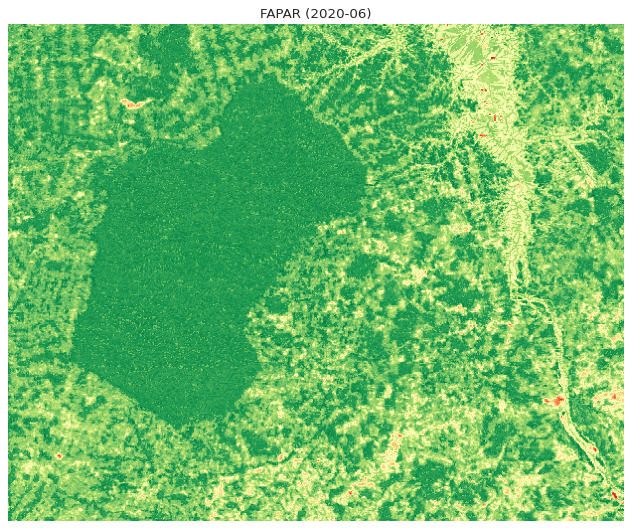

In [28]:
from skmap.plotter import plot_rasters
plot_rasters(pred_fapar, cmaps='RdYlGn', titles=f'FAPAR ({year}-{month})', dpi=80)

... and save the output raster using the same spatial resolution and extent of the input rasters:

In [29]:
save_rasters(raster_files[0], [f'fapar_automl_{year}-{month}_oemc.tif'], pred_fapar, dtype='uint8', nodata=255)

['fapar_automl_2020-06_oemc.tif']